<a href="https://colab.research.google.com/github/IqbalLx/Data-Bangalore-Image-Processing/blob/main/model_deployment_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

## Utils

In [2]:
def visualize_metrics(hist):
  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(hist.epoch, hist.history['loss'], label='Loss')
  plt.plot(hist.epoch, hist.history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(hist.epoch, hist.history['accuracy'], label='Acc')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

# Create Model

In [3]:
mnist = tf.keras.datasets.mnist

(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
training_images = training_images / 255.0
test_images = test_images / 255.

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="softmax")
  ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 16)                21648     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                        

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)

In [7]:
hist = model.fit(
    training_images, 
    training_labels, 
    batch_size=64, 
    validation_split=0.2, 
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
750/750 [==============================] - 19s 9ms/step - loss: 1.2245 - accuracy: 0.5452 - val_loss: 0.3716 - val_accuracy: 0.9277
Epoch 2/100
750/750 [==============================] - 6s 8ms/step - loss: 0.9123 - accuracy: 0.6424 - val_loss: 0.2520 - val_accuracy: 0.9518
Epoch 3/100
750/750 [==============================] - 6s 8ms/step - loss: 0.8427 - accuracy: 0.6683 - val_loss: 0.2145 - val_accuracy: 0.9578
Epoch 4/100
750/750 [==============================] - 4s 5ms/step - loss: 0.8063 - accuracy: 0.6834 - val_loss: 0.1786 - val_accuracy: 0.9613
Epoch 5/100
750/750 [==============================] - 4s 5ms/step - loss: 0.7865 - accuracy: 0.6984 - val_loss: 0.1752 - val_accuracy: 0.9623
Epoch 6/100
750/750 [==============================] - 4s 5ms/step - loss: 0.7609 - accuracy: 0.7089 - val_loss: 0.1621 - val_accuracy: 0.9638
Epoch 7/100
750/750 [==============================] - 4s 5ms/step - loss: 0.7481 - accuracy: 0.7180 - val_loss: 0.1616 - val_accuracy: 0.963

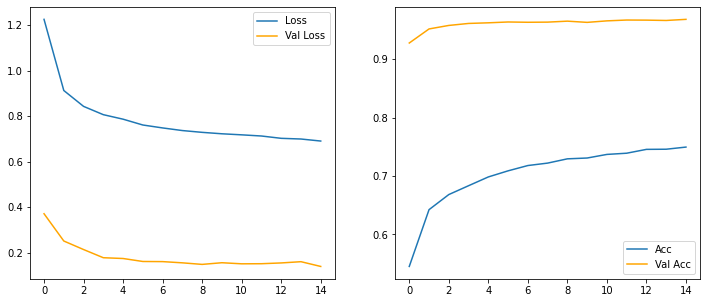

In [8]:
visualize_metrics(hist)

In [15]:
test_image = test_images[4]

print(test_labels[4])

4


In [16]:
test_image = np.expand_dims(test_image, axis=-1)
test_image = np.expand_dims(test_image, axis=0)

print(test_image.shape)

(1, 28, 28, 1)


In [17]:
out = model.predict(test_image)
max_index = np.argmax(out[0])

print(f"Predicted {max_index} with confidency {out[0][max_index] * 100:.2f}%")

Predicted 4 with confidency 98.39%


In [14]:
model.save("mnist_raw.h5")

# Convert Model into 

In [62]:
from typing import Callable, Tuple

class ServingInputReceiver:
    """
    A callable object that returns a 
    `tf.estimator.export.ServingInputReceiver` 
    object that provides a method to convert 
    `image_bytes` input to model.input
    """
    def __init__(
        self, img_size: Tuple[int], 
        preprocess_fn: Callable = None, 
        input_name: str = "input_1"):
        
        self.img_size = img_size[:2]
        self.channel = img_size[-1]
        self.preprocess_fn = preprocess_fn
        self.input_name = input_name
        
    def decode_img_bytes(self, img_b64: str) -> tf.Tensor:
        """
        Decodes a base64 encoded bytes and converts it to a Tensor.
        Args:
            img_bytes (str): base64 encoded bytes of an image file
        Returns:
            img (Tensor): a tensor of shape (width, height, 3)
        """
        img = tf.io.decode_image(
            img_b64, 
            channels=self.channel,
            dtype=tf.uint8,
            expand_animations=False
        )
        img = tf.image.resize(img, size=self.img_size)
        img = tf.ensure_shape(img, (*self.img_size, self.channel))
        img = tf.cast(img, tf.float32)
        return img
    
    def __call__(self) -> tf.estimator.export.ServingInputReceiver:
        # a placeholder for a batch of base64 string encoded of image bytes
        imgs_b64 = tf.compat.v1.placeholder(
            shape=(None,), 
            dtype=tf.string, 
            name="image_bytes")
        
        # apply self.decode_img_bytes() to a batch of image bytes (imgs_b64)
        imgs = tf.map_fn(
            self.decode_img_bytes, 
            imgs_b64, 
            dtype=tf.float32)
        
        # apply preprocess_fn if applicable
        if self.preprocess_fn:
            imgs = self.preprocess_fn(imgs)
        
        return tf.estimator.export.ServingInputReceiver(
            features={self.input_name: imgs},
            receiver_tensors={"image_bytes": imgs_b64}
        )

In [63]:
def preprocessing(image):
  return image / 255

In [75]:
serving_input_receiver = ServingInputReceiver(
    img_size=(28, 28, 1),
    preprocess_fn=preprocessing,
    input_name=model.input_names[0])

In [76]:
estimator_save_dir = "/content/estimators/mnist_estimator"
estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model,
    )

export_model_dir = "/content/mnist_serving/"  # this is where the exported model will end up. 
estimator.export_saved_model(
    export_dir_base=export_model_dir,
    serving_input_receiver_fn=serving_input_receiver)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpo82tv0nc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export 

b'/content/mnist_serving/1647768417'

In [77]:
!tar cvzf mnist_serving.tar.gz mnist_serving

mnist_serving/
mnist_serving/temp-1647768387/
mnist_serving/1647768417/
mnist_serving/1647768417/saved_model.pb
mnist_serving/1647768417/variables/
mnist_serving/1647768417/variables/variables.index
mnist_serving/1647768417/variables/variables.data-00001-of-00002
mnist_serving/1647768417/variables/variables.data-00000-of-00002


# Convert img to Base64

In [23]:
!pip3 install opencv-python

In [78]:
from cv2 import imencode
from base64 import b64encode
def encode_to_base64(image):
  _, jpg_buffer = imencode(".jpg", image)
  return b64encode(jpg_buffer).decode("utf8")


In [81]:
mnist = tf.keras.datasets.mnist

(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

In [88]:
test_img = test_images[4]
test_lbl = test_labels[4]

print(test_lbl)

4


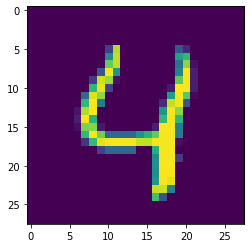

In [89]:
plt.imshow(test_img)

In [90]:
encode_to_base64(test_img)

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AP5/69C8efszfEz4b/s7fD79pzxRHZxeHPibqmuWXhaNZXNzJ/ZT2iXMzqUCiIyXaohVmJaGXIUBS2XH8EPiHP8AAib9pC30yGTwpbeLI/Dd1eJdIZINQktmuYkeLO4K8UcpV8bSYnGcjnka739lb4Lx/tH/ALTnw7/Z8m1xNMj8ceONK0GTUpHVRard3cUBly3A2iQnnjivd/8AgtF8c9H+In7bWvfAj4W6NNoXww+B8kngD4Z+F2t/JSxstPkaG4uCm1SZbq6We6eRx5rGZQ5yoA9e/bX+Hug/sQ/8ENv2fv2ZtR0fz/Gv7QPjGT4x+Ir6VSj6dpsNibHS7QKQCySQ3bzAkYD+bgkMK/O2rvhvxHr3g7xFYeLvCur3Gn6ppV7Feabf2kpSW2uInDxyow5VlZQwI6ECvsXWP+C+/wDwUX19P7V1nXPhrd+JisXm+Ob74L+HbnWpnjCqJZLmayYvIUUIXYEkE9+a9/8A+Ds74gan4x/bM+C2k67qf/E1039mzQG8Q6TG6xx6ZqU95qEk0TWygC2l2+UWQgHYYhtAUZ/K6ii